In [1]:
#reading data
import gzip 

#manipulating data 
import pandas as pd
import numpy as np
import datetime

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from math import pi

import plotly.express as px
import plotly.graph_objects as go

import random


#clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

#creating a map 
import folium 

#pca
from pca import pca

In [2]:
df_reviews_locations = pd.read_csv('../DataframeStorage/df_reviews_locations.csv')

/opt/anaconda3/envs/ada/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3135: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Map visualization for number of users

we start by plotting a map where we can visualize the different countries with the number of reviews per country:

We first define a df_country dataframe with the longitudes and latitudes of the world countries and US states in order to be able to plot maps. The data for the coordinates is taken from [here](https://www.mapsofworld.com/world-maps/world-map-with-latitude-and-longitude.html) and [here](https://www.mapsofworld.com/lat_long/usa-lat-long.html). There were some areas missing from the data we got so we added the missing locations manually using google maps coordinates.

In [ ]:
df_country_coordinates = pd.read_csv('../country2.csv')
df_country_coordinates = df_country_coordinates[['name','Latitude', 'Longitude']]

df_US_states_coordinates= pd.read_csv('../US_states.csv', index_col= 'name')
df_US_states_coordinates = df_US_states_coordinates.reset_index(level=0)
df_US_states_coordinates['name'] = df_US_states_coordinates['name'].apply(lambda x: 'United States, ' + x)

frames = [df_country_coordinates, df_US_states_coordinates]
df_coordinates = pd.concat(frames)
df_coordinates = df_coordinates.set_index('name')

Next we define a dataframe that contains the count of users from each country to plot the map:

In [ ]:
df_map = pd.DataFrame(df_reviews_locations['user_location'].value_counts())
df_map.index.name='name'

There are few locations where the name in df_reviews_locations differs from the one in the country coordinates we have. Also there are a two countries reffered to in two different ways. So we change them accordingly:

In [ ]:
df_map = df_map.rename(index={'Virgin Islands (British)': 'British Virgin Islands', 'Virgin Islands (U.S.)':'U.S. Virgin Islands'})
df_map.loc['New Zealand']=df_map.loc['Aotearoa']['user_location']+df_map.loc['New Zealand']['user_location']
df_map.loc['Slovakia']=df_map.loc['Slovakia']['user_location']+df_map.loc['Slovak Republic']['user_location']

We join the coordinate data with the user location count data:

In [ ]:
df_map = df_map.join(df_coordinates)
df_map = df_map.dropna(axis=0)

Next we plot the data on a map using plotly:

In [ ]:
# Create the figure and plot
fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon=df_map['Longitude'],
    lat=df_map['Latitude'],
    text=df_map.index,
    marker=go.scattergeo.Marker(
        size=df_map['user_location'],
        sizemode='area',
        sizeref=2*max(df_map['user_location'])/(100**2),
        sizemin=1,
    ),

    hovertext=df_map.index,
    hoverinfo='text',
    hovertemplate='Country: %{text}<br>Number of reviewers: %{marker.size:.0f}<extra></extra>',
    mode='markers'
))


# Customize the layout and show the plot
fig.update_layout(
    geo=go.layout.Geo(
        showframe=True,
        showcoastlines=True,
        projection_type='natural earth2',
        showcountries= True
    ),
    hovermode='closest',
    width=1200,
    height=900,
    title='World Map with number of users per country',
    paper_bgcolor= 'rgba(0,0,0,0)',
)

fig.show()
fig.write_html('../plots_html/map.html')

## Barplots :

In [3]:
good_beers_user_location_counts = pd.DataFrame(df_reviews_locations.loc[df_reviews_locations['rating']>4]['user_merged_location'].value_counts())
good_beers_user_location_counts = good_beers_user_location_counts.rename(columns={"user_merged_location": "Number of users"})

In [5]:
good_beers_user_location_counts_1000 = good_beers_user_location_counts.loc[good_beers_user_location_counts['Number of users']>1000]

In [6]:
df_country_barplot = pd.DataFrame (columns = ['Local brewery','Out of country/state brewery'],
                                  index = good_beers_user_location_counts_1000.index)

In [7]:
for country in good_beers_user_location_counts_1000.index:
    location_users_data = df_reviews_locations[df_reviews_locations['user_merged_location'] == country]
    dummy_location = (location_users_data['brewery_merged_location']== country).astype(int)
    proportions = dummy_location.value_counts(normalize= True)
    df_country_barplot.loc[country]['Local brewery']=proportions[1]
    df_country_barplot.loc[country]['Out of country/state brewery']=proportions[0]

In [ ]:
df_country_barplot.reset_index(inplace=True)
df_country_barplot = df_country_barplot.rename(columns = {'index':'Countries'})

In [ ]:
# Set the data for the plot
x = df_country_barplot['Countries']
y1 = df_country_barplot['Out of country/state brewery']
y2 = df_country_barplot['Local brewery']

# Create the figure and plot
fig = go.Figure()
fig.add_trace(go.Bar(x=x, y=y2, name='Local brewery', base=0))
fig.add_trace(go.Bar(x=x, y=y1, name='Out of country brewery', base=y2))


# Customize the layout and show the plot
fig.update_layout(barmode='stack', yaxis=dict(title='Frequency'), title='Proportions of users for very well rated beers (rating>4)', title_x= 0.5, paper_bgcolor= 'rgba(0,0,0,0)')
fig.show()

fig.write_html('../plots_html/barplot_countries_final.html')

### By state

In [ ]:
#We start by observing where the users who rate beers more than 4 out of 5 come from:
good_beers_user_location_US = df_reviews_locations.loc[df_reviews_locations['user_location'].str.startswith('United States')]
good_beers_user_location_US_counts = pd.DataFrame(good_beers_user_location_US.loc[good_beers_user_location_US['rating']>4]['user_location'].value_counts())
good_beers_user_location_US_counts = good_beers_user_location_US_counts.rename(columns={"user_merged_location": "Number of users"})

In [ ]:
df_states_barplot = pd.DataFrame (columns = ['Local brewery','Out of country/state brewery'],
                                  index = good_beers_user_location_US_counts.index)

In [ ]:
for state in good_beers_user_location_US_counts.index:
    location_users_data = df_reviews_locations[df_reviews_locations['user_location'] == state]
    dummy_location = (location_users_data['brewery_location']== state).astype(int)
    proportions = dummy_location.value_counts(normalize= True)
    df_states_barplot.loc[state]['Local brewery']=proportions[1]
    df_states_barplot.loc[state]['Out of country/state brewery']=proportions[0]

df_states_barplot.reset_index(inplace=True)

In [ ]:
df_states_barplot = df_states_barplot.rename(columns = {'index':'States'})

In [ ]:
# Set the data for the plot
x = df_states_barplot['States']
y1 = df_states_barplot['Out of country/state brewery']
y2 = df_states_barplot['Local brewery']

# Create the figure and plot
fig = go.Figure()
fig.add_trace(go.Bar(x=x, y=y2, name='Local brewery', base=0))
fig.add_trace(go.Bar(x=x, y=y1, name='Out of country brewery', base=y2))

# Customize the layout and show the plot
fig.update_layout(barmode='stack', yaxis=dict(title='Frequency'), title='Proportions of users for very well rated beers (rating>4) in the United States', title_x= 0.5, paper_bgcolor= 'rgba(0,0,0,0)')
fig.show()

fig.write_html('../plots_html/barplot_states.html')

## Maps

## PLEASE NOTE: the maps and radar plot below are not the exact same as the ones on the website because everytime the k-means clustering is run the cluster names are different but the clusters are similar 

### Reviews with rating>4

In [ ]:
df_reviews_all_good_beers = df_reviews_locations.loc[df_reviews_locations['rating']>4]

Next we define df_beer_style_score which contains a vector per country containing the normalized percentages of the number of reviews that review a certain style of beer (for ratings higher than 4):

In [ ]:
countries = df_reviews_all_good_beers['user_location'].unique() #a vector containing the list of unique countries
df_beer_style_score_good = pd.DataFrame(index=df_reviews_all_good_beers['style'].unique()) #define a DataFrame where the indices are all the beer styles

for country in countries:
    df_country = pd.DataFrame(df_reviews_all_good_beers.loc[df_reviews_all_good_beers['user_location']==country]['style'].value_counts(normalize= True).reindex(df_reviews_all_good_beers['style'].unique(), fill_value=0)) #puts 0's for the values where the count was 0
    df_country = df_country.rename(columns={ "style": country})
    df_beer_style_score_good = df_beer_style_score_good.join(df_country)

df_beer_style_score_good = df_beer_style_score_good.T

In [ ]:
# Initialize
model = pca()
# Fit transform
out = model.fit_transform(df_beer_style_score_good)

# Print the top features. The results show that f1 is best, followed by f2 etc
print(out['topfeat'])

#     PC      feature
# 0  PC1      f1
# 1  PC2      f2
# 2  PC3      f3
# 3  PC4      f4
# 4  PC5      f5
# 5  PC6      f6
# 6  PC7      f7
# 7  PC8      f8
# 8  PC9      f9

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [178] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [42] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [178] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[42]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
       PC                       feature   loading  type
0     PC1                    Pale Lager  0.980292  best
1     PC2                Imperial Stout  0.696139  best
2     PC3                   Malt Liquor  0.918376  best
3     PC4                     Brown Ale  0.964629  best
4     PC5            Belgian Strong Ale  0.532003  best
..    ...                           ...       ...   ...
177  

So we select the 42 features corresponding to the those top features:

In [ ]:
top_features = out['topfeat'].head(42).feature
df_beer_style_score_good = df_beer_style_score_good[top_features]

Next we perform K-means clutering. In order to select the optimal number of clusters, we run k-means over a range of values of K (number of clusters) and for each value we calculate the average distances to the centroid across all data points, we plot the result to find the point where the average distance from the centroid falls suddenly (the elbow of the curve):

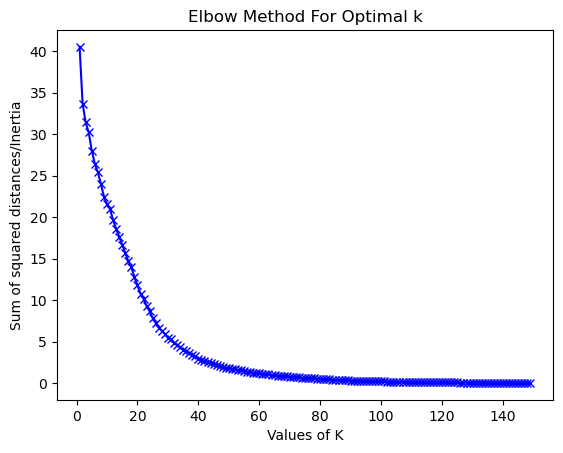

In [ ]:
Sum_of_squared_distances = []
K = range(1,150)

for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(df_beer_style_score_good)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

It looks like the elbow is around the value of K=35

In [ ]:
#running k-means with the found optimal k
kmeans = KMeans(35)
kmeans.fit(df_beer_style_score_good)
clusters=kmeans.fit_predict(df_beer_style_score_good)

In [ ]:
clusters_data=df_beer_style_score_good.copy()
#assigning the clusters to the data 
clusters_data['Cluster']=clusters

Next we want to plot the clusters on a map, so we use data with the longitutde and latitudes of each country and each state in the United States: 

In [ ]:
plotting_data = clusters_data.join(df_coordinates)
plotting_data = plotting_data.dropna(axis=0)

Finally, let's visualize the map with  Plotly:

In [ ]:
fig = go.Figure(data=go.Scattergeo(
        lon = plotting_data['Longitude'],
        lat = plotting_data['Latitude'],
        text = plotting_data.index,
        hovertext=plotting_data.index,
        hoverinfo='text',
        mode = 'markers',
        marker_color = plotting_data['Cluster'],
        hovertemplate='%{text}<br>Cluster: %{marker.color}<extra></extra>'
        ))

# Customize the layout and show the plot
fig.update_layout(
    geo=go.layout.Geo(
        showframe=True,
        showcoastlines=True,
        projection_type='natural earth2',
        showcountries= True
    ),
    hovermode='closest',
    paper_bgcolor = 'rgba(0,0,0,0)',
    width=1200,
    height=900,
    title='World Map with style clusters'
)
fig.show()

fig.write_html('../plots_html/map1.html')


### Taking all ratings into account:

In [ ]:
#loading that dataframe
df_beer_style_score = pd.read_csv('../DataframeStorage/style_scores.csv' , index_col='Unnamed: 0')

In [ ]:
df_beer_style_score.head(1)

,Pale Lager,American IPA,India Pale Ale (IPA),Imperial Stout,Golden Ale/Blond Ale,Euro Pale Lager,Amber Lager/Vienna,Pilsener,Malt Liquor,Porter,...,Baltic Porter,Amber Ale,Fruit Beer,Spice/Herb/Vegetable,Barley Wine,English Porter,Zwickel/Keller/Landbier,Cluster,Latitude,Longitude
"United States, Washington",0.084424,0.357018,0.462548,0.25401,0.055105,0.012461,0.032079,0.061046,0.010246,0.147742,...,0.050027,0.116571,0.075734,0.108029,0.14113,0.014529,0.010019,4,47.751074,-120.740139


In [ ]:
df_beer_style_score.drop(["Cluster", "Latitude",'Longitude'], axis = 1, inplace=True)

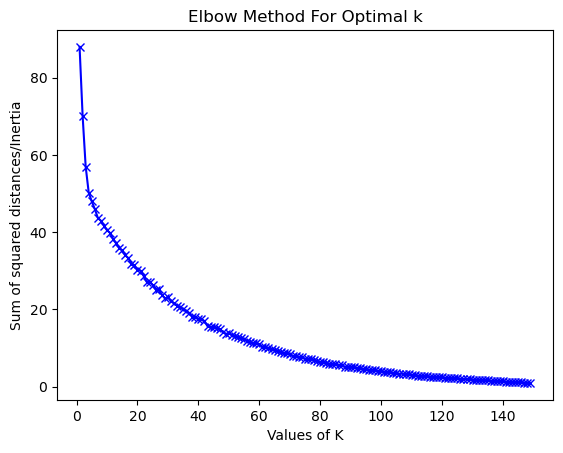

In [ ]:
Sum_of_squared_distances = []

K = range(1,150)

for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(df_beer_style_score)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
kmeans = KMeans(25)
kmeans.fit(df_beer_style_score)
clusters=kmeans.fit_predict(df_beer_style_score)

In [ ]:
clusters_data = df_beer_style_score.copy()
clusters_data['Cluster']=clusters

plotting_data = clusters_data.join(df_coordinates)
plotting_data = plotting_data.dropna(axis=0)

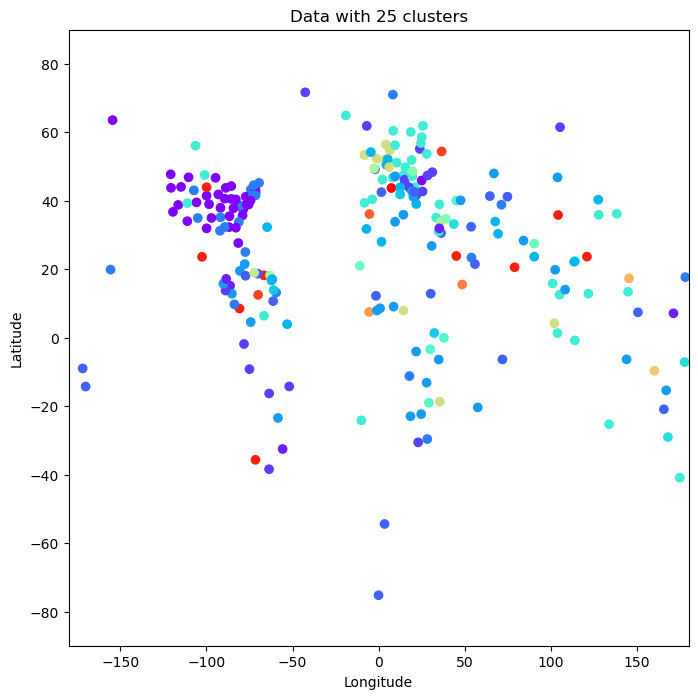

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(plotting_data['Longitude'],plotting_data["Latitude"],c=plotting_data['Cluster'],cmap='rainbow')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Data with 25 clusters") 
plt.xlim(-180,180)
plt.ylim(-90, 90)
plt.show()

In [ ]:
fig = go.Figure(data=go.Scattergeo(
        lon = plotting_data['Longitude'],
        lat = plotting_data['Latitude'],
        text = plotting_data.index,
        hovertext=plotting_data.index,
        hoverinfo='text',
        mode = 'markers',
        marker_color = plotting_data['Cluster'],
        hovertemplate='%{text}<br>Cluster: %{marker.color}<extra></extra>',
        ))

# Customize the layout and show the plot
fig.update_layout(
    geo=go.layout.Geo(
        showframe=True,
        showcoastlines=True,
        projection_type='natural earth2',
        showcountries= True
    ),
    hovermode='closest',
    width=1200,
    height=900,
    title='World Map with style preference clusters',
    paper_bgcolor = 'rgba(0,0,0,0)'
)

fig.show()

fig.write_html('../plots_html/map2.html')

We definitely see major region clusters on this map, the largest 10 clusters are represented below:

In [ ]:
print('The largest clusters of countries are:')
clusters_data['Cluster'].value_counts().head(10)

The largest clusters of countries are:


9     38
0     34
5     30
4     24
3     19
2     18
6     15
16     9
23     9
1      5
Name: Cluster, dtype: int64

We consider some of the clusters and want to identify which styles they like and how they do so:

- Cluster 9 corresponds to mostly European countries (including Germany, Denmark, France, Switzerland etc.) and other countries around the world that do not cluster in a specific way
- Cluster 0 contains most states from the United States
- Cluster 2 contains a lot of south american countries
- Cluster 4 contains states from the east coast of the United States

The other large clusters had countries spread out in the world without any particular geographical/regional clustering so we omit them for the following analysis:

In [ ]:
cluster_vectors = clusters_data.groupby('Cluster').mean()
indices_clusters = [ 9,  0,  2, 4]
radar_plot_data = cluster_vectors.iloc[indices_clusters]

In [ ]:
radar_plot_data

,Pale Lager,American IPA,India Pale Ale (IPA),Imperial Stout,Golden Ale/Blond Ale,Euro Pale Lager,Amber Lager/Vienna,Pilsener,Malt Liquor,Porter,...,Irish Ale,Dry Stout,English Pale Ale,Baltic Porter,Amber Ale,Fruit Beer,Spice/Herb/Vegetable,Barley Wine,English Porter,Zwickel/Keller/Landbier
Cluster,,,,,,,,,,,,,,,,,,,,,
9,0.208863,0.034842,0.528619,0.277967,0.107594,0.012639,0.053776,0.130324,0.008728,0.140967,...,0.022142,0.035551,0.042233,0.046922,0.107899,0.080505,0.118617,0.080839,0.004621,0.045779
0,0.104459,0.353194,0.388949,0.278268,0.052707,0.017886,0.045462,0.059668,0.009883,0.141269,...,0.020341,0.034156,0.054005,0.052022,0.093887,0.087616,0.107632,0.118438,0.022835,0.011157
2,0.472086,0.023198,0.399137,0.123523,0.098583,0.040391,0.087561,0.171018,0.012796,0.142507,...,0.027665,0.058443,0.039242,0.086690,0.091950,0.091237,0.108367,0.055718,0.004661,0.037189
4,0.078445,0.504354,0.119154,0.071638,0.043164,0.053616,0.019142,0.020850,0.003946,0.049213,...,0.014500,0.014919,0.079634,0.041458,0.035088,0.030459,0.031484,0.029657,0.052681,0.002625


We want to plot a radar plot with the most interesting categories of beer according to the clusters, since there are 41 styles of beers we extract the ones with the highest absolute value for loadings on PC1 :

In [ ]:
most_present_styles = abs(out['loadings'].loc['PC1']).sort_values(ascending= False).head(30).index

In [ ]:
radar_plot_df =  radar_plot_data.loc[:, radar_plot_data.columns.isin(most_present_styles)]

We want the radar plot to have the categories spread out and not in a particular order so we generate a df_radar_shuffled which contains the same data as above but with the columns shuffled:

In [ ]:
# Generate a random permutation of the column indices
perm = np.random.permutation(radar_plot_df.shape[1])

# Shuffle the column order of the dataframe
df_radar_shuffled = radar_plot_df.iloc[:, perm]
df_radar_shuffled.reset_index(inplace=True)
df_radar_shuffled = df_radar_shuffled.rename(columns = {'index':'Cluster'})

df_radar_shuffled

,Cluster,Spice/Herb/Vegetable,English Stout,Barley Wine,Dunkel/Tmavý,Belgian Strong Pale Ale,Milk / Sweet Stout,Bitter,Brown Ale,Fruit Beer,...,Cream Ale,Euro Pale Lager,American IPA,Pale Lager,Pilsener,Baltic Porter,Porter,English Porter,Premium Bitter/ESB,Russian Imperial Stout
0,9,0.118617,0.002019,0.080839,0.077308,0.010485,0.004419,0.069230,0.081176,0.080505,...,0.009569,0.012639,0.034842,0.208863,0.130324,0.046922,0.140967,0.004621,0.069758,0.011456
1,0,0.107632,0.006342,0.118438,0.027496,0.054429,0.045286,0.023534,0.097665,0.087616,...,0.024331,0.017886,0.353194,0.104459,0.059668,0.052022,0.141269,0.022835,0.056109,0.128991
2,2,0.108367,0.002703,0.055718,0.125115,0.016437,0.003009,0.053451,0.066143,0.091237,...,0.004001,0.040391,0.023198,0.472086,0.171018,0.086690,0.142507,0.004661,0.085735,0.015679
3,4,0.031484,0.008851,0.029657,0.008698,0.063882,0.058073,0.019102,0.035297,0.030459,...,0.017187,0.053616,0.504354,0.078445,0.020850,0.041458,0.049213,0.052681,0.024439,0.153335


In [ ]:
#radar plot
# number of variable
categories=(list(df_radar_shuffled)[1:])

data1 = df_radar_shuffled.loc[0].drop('Cluster').values.flatten().tolist()
data2 = df_radar_shuffled.loc[1].drop('Cluster').values.flatten().tolist()
data3 = df_radar_shuffled.loc[2].drop('Cluster').values.flatten().tolist()
data4 = df_radar_shuffled.loc[3].drop('Cluster').values.flatten().tolist()


# Create the figure and plot
fig = go.Figure()
fig.add_trace(go.Scatterpolar(r=data1, theta=categories, fill='toself', name='Cluster 7'))
fig.add_trace(go.Scatterpolar(r=data2, theta=categories, fill='toself', name='Cluster 4'))
fig.add_trace(go.Scatterpolar(r=data3, theta=categories, fill='toself', name='Cluster 10'))
fig.add_trace(go.Scatterpolar(r=data4, theta=categories, fill='toself', name='Cluster 6'))

# Customize the layout and show the plot
fig.update_layout(
    polar=go.layout.Polar(
        radialaxis=go.layout.polar.RadialAxis(
            visible=True,
            range=[0, 0.6]
        )
    ),
    showlegend=True,
    width=800,
    height=600,
    title='Radar Plot for the different styles of beer per cluster',
    paper_bgcolor = 'rgba(0,0,0,0)'
)

fig.write_html('../plots_html/radar_plot.html')
fig.show()